# NoteBook Setup




> The cell below are will install all the necessary python packages required for the notebook to function

In [ ]:
#This cell denotes the required packages for the notebook to work
pip install mysql-connector-python numpy pandas seaborn matplotlib plotly sqlalchemy

In [ ]:
#Library import

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import sqlalchemy

# Database Connection


In [ ]:
#This cell creates a link to to database and extract all the tables.
import streamlit as st

# Establish the database connection using a SQLAlchemy engine.
db_connection_str = st.secrets.get("DB_CONNECTION_STRING")
if not db_connection_str:
    raise ValueError("No DB_CONNECTION_STRING found in environment or Streamlit secrets.")
engine = sqlalchemy.create_engine(db_connection_str)

# Get a list of all table names from the database and filter for 'long' tables.
inspector = sqlalchemy.inspect(engine)
all_tables = inspector.get_table_names()
long_tables = [table for table in all_tables if table.endswith('long')]
wide_tables = [table for table in all_tables if table.endswith('wide')]

#get first elemtn of wide_tables to make into pd.dataframe
df_wide = pd.read_sql(f"SELECT * FROM {wide_tables[0]}", engine)
df_long = pd.read_sql(f"SELECT * FROM {long_tables[0]}", engine)

#iterate through long_tables and store it into a dict df_long_dict
df_long_dict = {}
for table in long_tables:
    df_long_dict[table] = pd.read_sql(f"SELECT * FROM {table}", engine)

#iterate through wide_tables and store it into a dict df_wide_dict
df_wide_dict = {}
for table in wide_tables:
    df_wide_dict[table] = pd.read_sql(f"SELECT * FROM {table}", engine)


SecretNotFoundError: Secret db_conn does not exist.

In [ ]:
#loop through df_long_dict and change all year from int type to to_datetime(df['year'], format="%Y")
for key, value in df_long_dict.items():
    df_long_dict[key]['year'] = pd.to_datetime(df_long_dict[key]['year'], format="%Y")

#FirstDraft


## Module 2 ( Data Cleaning )

### Additional Data (Plot out employed workforce by reserve calculation from 2 tables)

#### df_long_dict["employed_by occupation_long"]

In [ ]:
# Get total unemployed_count per occupation (sum male + female)
df_unemp = df_long_dict['unemployed_by_previous_occupation_sex_long']
unemp_sum = df_unemp.groupby(['year', 'occupation'])['unemployed_count'].sum().reset_index()

# Get unemployed_rate per occupation
df_rate = df_long_dict["unemployment_rate_by_occupation_long"][['year', 'occupation', 'unemployed_rate']]

# Merge on year and occupation
merged = pd.merge(unemp_sum, df_rate, on=['year', 'occupation'], how='inner')

# Convert unemployed_rate from percent to proportion
merged['unemployed_rate_prop'] = merged['unemployed_rate'] / 100

# Calculate employed_count
merged['employed_count'] = merged['unemployed_count'] * (1 / merged['unemployed_rate_prop'] - 1)

# Final DataFrame with employed_count and occupation
result_df = merged[['year', 'occupation', 'employed_count']]

df_long_dict["employed_by occupation_long"] = result_df

NameError: name 'df_long_dict' is not defined

#### df_long_dict["employed_by occupation_sex_long"]

In [ ]:
# Get unemployed_count per year, occupation, gender
df_unemp = df_long_dict['unemployed_by_previous_occupation_sex_long']
unemp_sum = df_unemp.groupby(['year', 'occupation', 'gender'])['unemployed_count'].sum().reset_index()

# Get unemployed_rate per year, occupation (rate is for total, not by gender)
df_rate = df_long_dict["unemployment_rate_by_occupation_long"][['year', 'occupation', 'unemployed_rate']]

# Merge on year and occupation (rate will be duplicated for both genders)
merged = pd.merge(unemp_sum, df_rate, on=['year', 'occupation'], how='inner')

# Convert unemployed_rate from percent to proportion
merged['unemployed_rate_prop'] = merged['unemployed_rate'] / 100

# Calculate employed_count per gender
merged['employed_count'] = merged['unemployed_count'] * (1 / merged['unemployed_rate_prop'] - 1)

# Final DataFrame with employed_count, occupation, gender
result_df = merged[['year', 'occupation', 'gender', 'employed_count']]

df_long_dict["employed_by occupation_sex_long"] = result_df

df_long_dict["employed_by occupation_sex_long"]

### Data Checking

> The cell below will do a inital check on the datas imported into the sql database. It loops though all the tables and print out the necessary information.

In [ ]:
#Explore Data
import pandas as pd

# Loop through the filtered list of tables.
for table_name, df in df_long_dict.items():
    print(f"--- Processing table: '{table_name}' ---")

    # Show the .info() for the DataFrame.
    print("DataFrame Info:")
    df.info()

    # Showf"\nDescriptive Statistics of '{table_name}':")
    print(f"\nDescriptive Statistics of '{table_name}':")
    print(df.describe())

    # Show the .head() for the DataFrame.
    print(f"\nFirst 5 rows of '{table_name}':")
    print(df.head())

    # Show the categorical values for the DataFrame.
    print(f"\nValue Counts for Categorical Columns in '{table_name}':")
    for col in df.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumn: {col}")
        print(df[col].value_counts(dropna=False))

    # Show Duplicates
    print(f"\nDuplicates in '{table_name}':")
    duplicates_all = df[df.duplicated(keep=False)]
    print(duplicates_all)

    # Print a separator for clarity.
    print("\n" + "="*80 + "\n")

--- Processing table: 'long_term_unemployed_pmets_by_age_long' ---
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   year              88 non-null     datetime64[ns]
 1   pmets_status      88 non-null     object        
 2   age_group         88 non-null     object        
 3   unemployed_count  88 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.9+ KB

Descriptive Statistics of 'long_term_unemployed_pmets_by_age_long':
                                year  unemployed_count
count                             88         88.000000
mean   2019-01-01 02:10:54.545454592         10.250000
min              2014-01-01 00:00:00          4.200000
25%              2016-01-01 00:00:00          7.475000
50%              2019-01-01 00:00:00          8.900000
75%              2022

### Find Outliers

Next we loop through the tables again and look for outliers through histogram and boxplot. Extreme data are annotated and displayed.

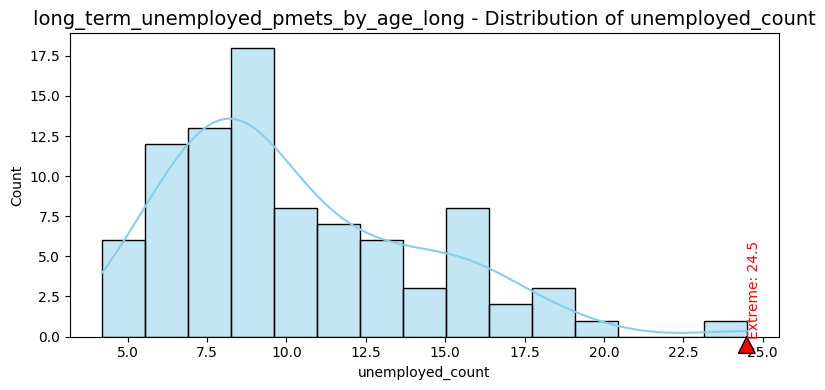

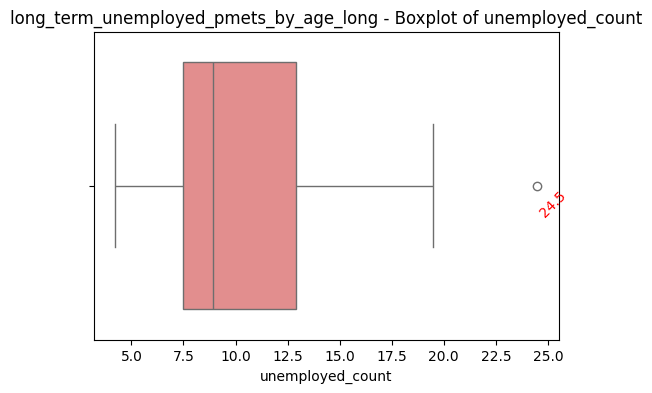

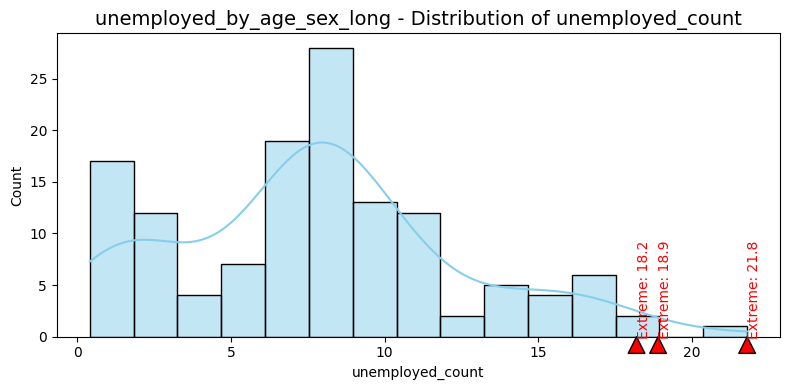

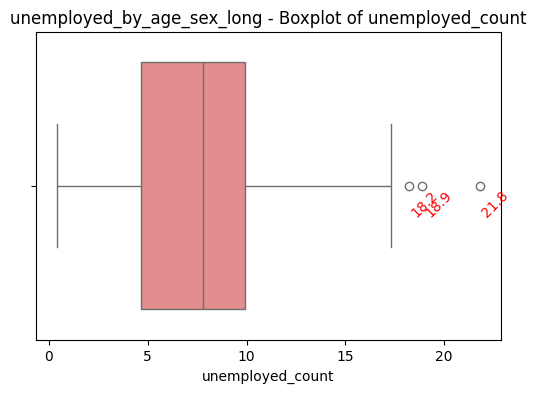

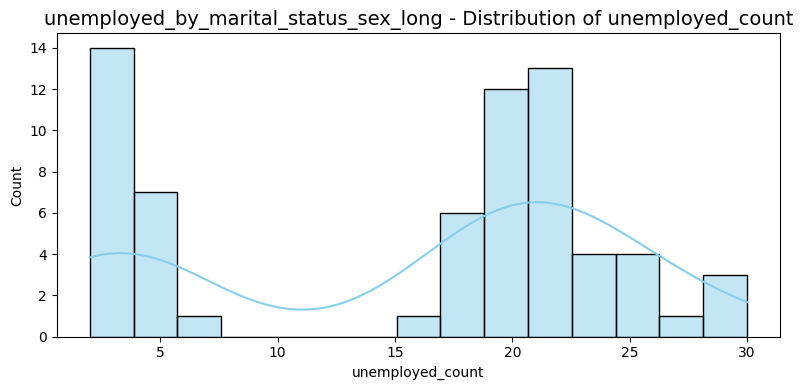

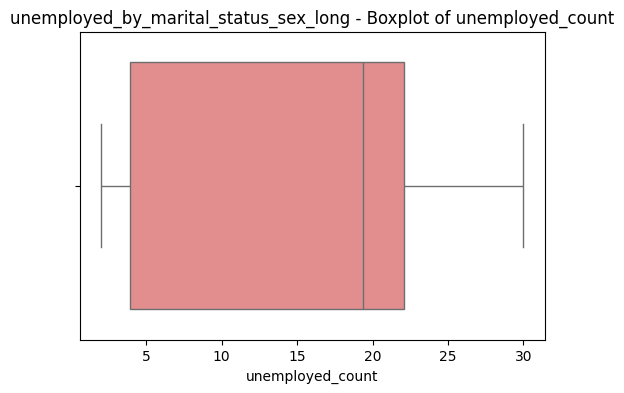

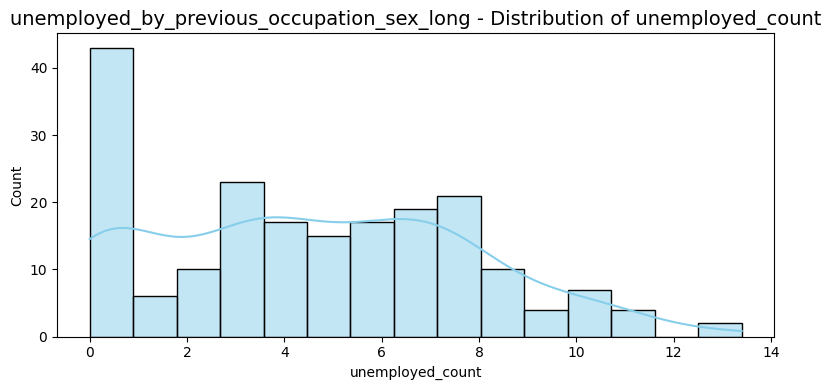

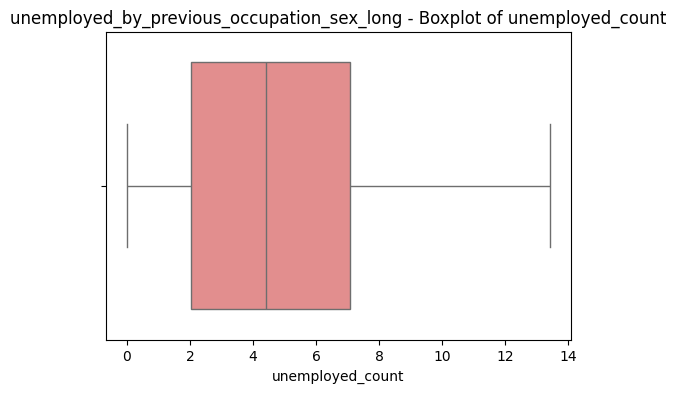

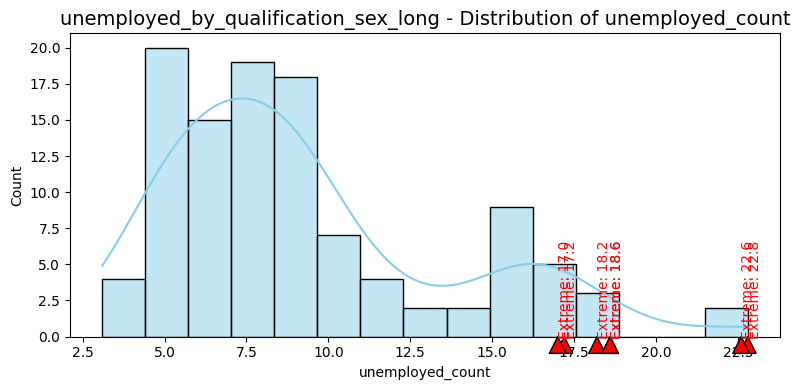

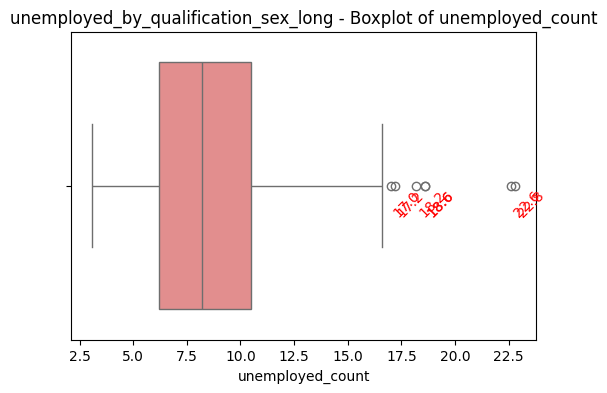

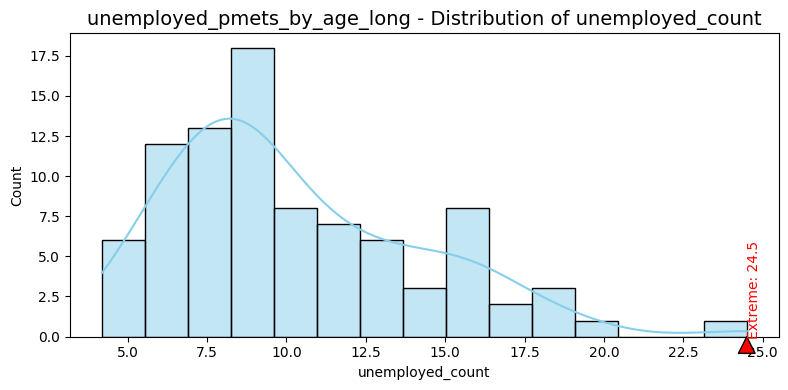

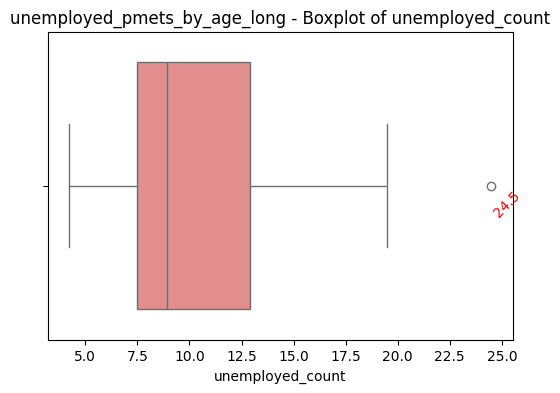

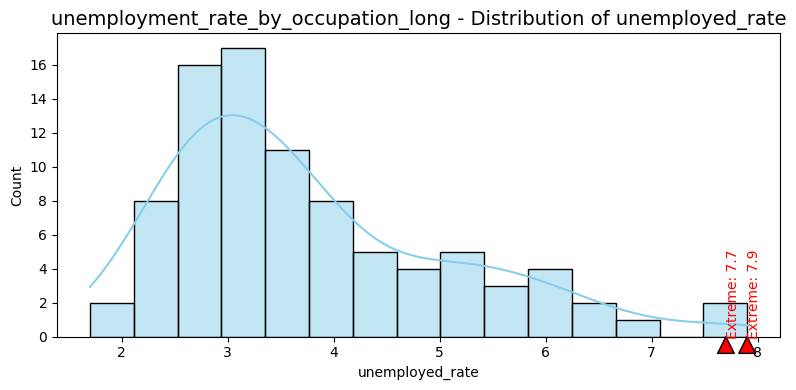

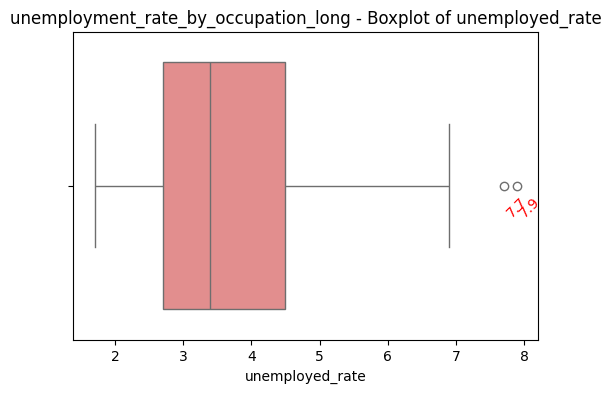

In [ ]:
for table_name, df in df_long_dict.items():
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], bins=15, kde=True, color='skyblue')
        plt.title(f'{table_name} - Distribution of {col}', fontsize=14)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.tight_layout()

        # Annotate extreme values
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper = q3 + 1.5*iqr
        lower = q1 - 1.5*iqr
        outliers = df[(df[col] < lower) | (df[col] > upper)][col]

        # Annotate outliers
        for val in outliers:
             plt.annotate(f'Extreme: {val}', xy=(val, 0), xytext=(val, max(ax.get_ylim())*0.05),
                         arrowprops=dict(facecolor='red', shrink=0.05), rotation=90, color='red')
        plt.show()

        # Boxplot to visualize outliers
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.boxplot(x=df[col], color='lightcoral', ax=ax)
        ax.set_title(f'{table_name} - Boxplot of {col}', fontsize=12)

        # Annotate outliers
        for val in outliers:
            ax.annotate(f'{val}', xy=(val, 0), xytext=(val, 0.1),
                        textcoords='data', rotation=45, color='red')

        plt.show()

## Module 3 ( Data Visualizing )

### Main Research Question:
How have different industries and occupations contributed to the unemployment rate in Singapore?


**Hypothesis**

Lower-skilled occupations such as service, sales, clerical support, and manual labour consistently have higher unemployment rates compared to higher-skilled occupations such as managers and professionals in Singapore.

**Predictions**

Lower-skilled occupations will continue to have higher unemployment rates.
Examples of predictive questions:
How are unemployment rates in lower-skilled occupations likely to trend compared to higher-skilled occupations?
Which occupations are at greater risk of higher unemployment rates in the coming years?
What is the projected unemployment rate for lower-skilled occupations relative to other groups?




 ### Unemployment rates in Singapore by occupation group (2014–2024).


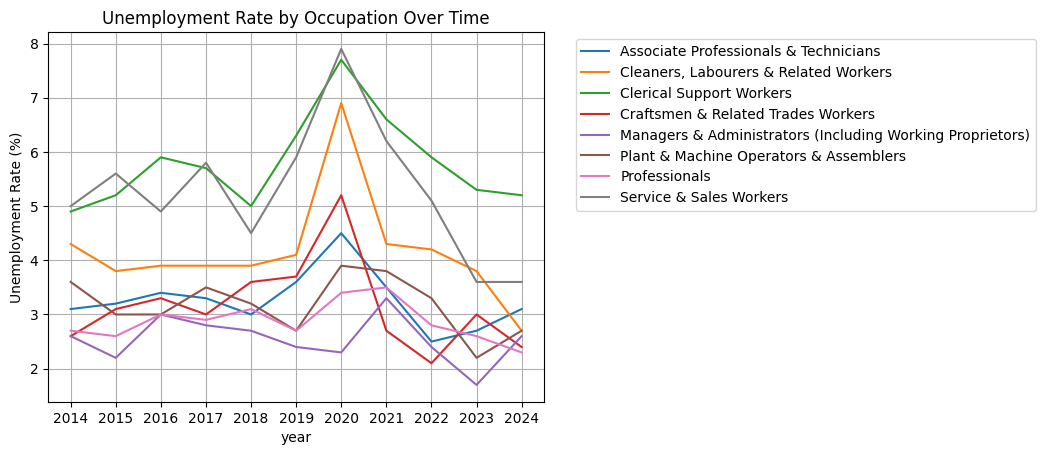

In [ ]:
# Unemployment Rate by Occupation Over Time - Trend Analysis
df = df_long_dict["unemployment_rate_by_occupation_long"]

sns.lineplot(
  data=df,
  x="year",
  y="unemployed_rate",
  hue="occupation"
)
plt.title("Unemployment Rate by Occupation Over Time")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

 Clerical support, service, and manual labor occupations show persistently higher unemployment compared to professionals and managers, with the sharpest spike during the 2020 downturn.

### Unemployment rates in Singapore by skill level (2014–2024).

In [ ]:
df = df_long_dict["unemployment_rate_by_occupation_long"]

high_skill = ["Professionals", "Managers & Administrators (Including Working Proprietors)","Associate Professionals & Technicians"]
low_skill = ["Cleaners, Labourers & Related Workers", "Service & Sales Workers","Clerical Support Workers", "Craftsmen & Related Trades Workers","Plant & Machine Operators & Assemblers"]

df["skill_level"] = df["occupation"].apply(
    lambda x: "High Skill" if x in high_skill else ("Low Skill" if x in low_skill else "Other")
)

sns.lineplot(
    data=df,
    x="year",
    y="unemployed_rate",
    hue="skill_level"
)
plt.title("Unemployment Rate: High vs Low Skill Occupations")
plt.show()

NameError: name 'df_long_dict' is not defined

 > Lower-skilled occupations consistently face higher unemployment than higher-skilled occupations, with a sharper spike during the 2020 downturn and a slower recovery thereafter.

### Unemployment rates in Singapore by occupation group, segmented by periods (2014–2016, 2017–2019, 2020–2021, 2022–2024).

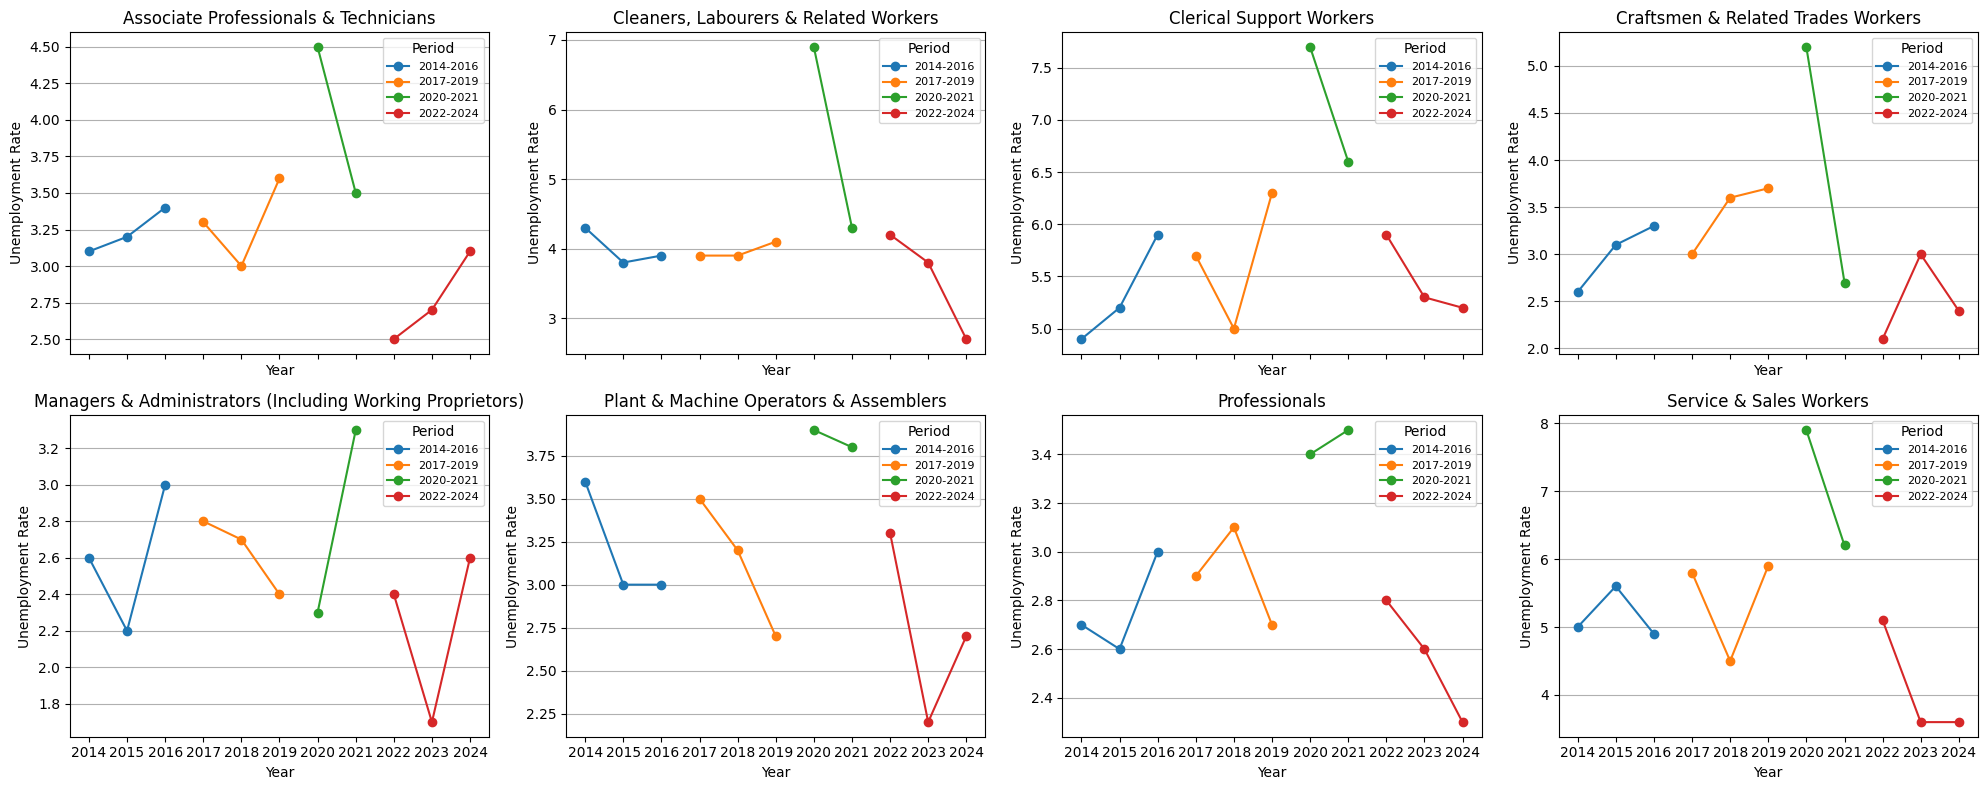

In [ ]:
import plotly.express as px

df = df_long_dict['unemployment_rate_by_occupation_long']

# Ensure 'year' is datetime
df['year'] = pd.to_datetime(df['year'], errors='coerce')

# List for legend order (if you want a specific order)
occupation_order = [
    'Managers & Administrators (Including Working Proprietors)',
    'Professionals',
    'Associate Professionals & Technicians',
    'Clerical Support Workers',
    'Service & Sales Workers',
    'Craftsmen & Related Trades Workers',
    'Plant & Machine Operators & Assemblers',
    'Cleaners, Labourers & Related Workers',
    'Others'
]

# Segregate df_long by the specified periods
periods = {
    '2014-2016': (pd.Timestamp('2014-01-01'), pd.Timestamp('2016-12-31')),
    '2017-2019': (pd.Timestamp('2017-01-01'), pd.Timestamp('2019-12-31')),
    '2020-2021': (pd.Timestamp('2020-01-01'), pd.Timestamp('2021-12-31')),
    '2022-2024': (pd.Timestamp('2022-01-01'), pd.Timestamp('2024-12-31')),
}

import matplotlib.pyplot as plt

# Assume df_long_dict['unemployment_rate_by_occupation_long'] is available
df_occ = df_long_dict['unemployment_rate_by_occupation_long'].copy()
df_occ['year'] = pd.to_datetime(df_occ['year'])

# Segregate by period
df_occ_periods = {}
for label, (start, end) in periods.items():
    df_occ_periods[label] = df_occ[(df_occ['year'] >= start) & (df_occ['year'] <= end)]

occupations = sorted(df_occ['occupation'].unique())
n_occ = len(occupations)
ncols = 4
nrows = (n_occ + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharex=True)
axes = axes.flatten()

for i, occ in enumerate(occupations):
    ax = axes[i]
    for label, df_period in df_occ_periods.items():
        sub = df_period[df_period['occupation'] == occ]
        ax.plot(sub['year'], sub['unemployed_rate'], marker='o', label=label)
    ax.set_title(occ)
    ax.set_xlabel('Year')
    ax.set_ylabel('Unemployment Rate')
    ax.grid(True, axis='y')
    ax.legend(title='Period', fontsize=8)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


>  The charts highlight how lower-skilled occupations such as Clerical Support Workers, Service & Sales Workers, and Cleaners experienced sharper unemployment spikes during 2020–2021, while higher-skilled occupations such as Managers and Professionals remained more resilient with smaller fluctuations.




### Heatmap of unemployment rates in Singapore by occupation and year (2014–2024).

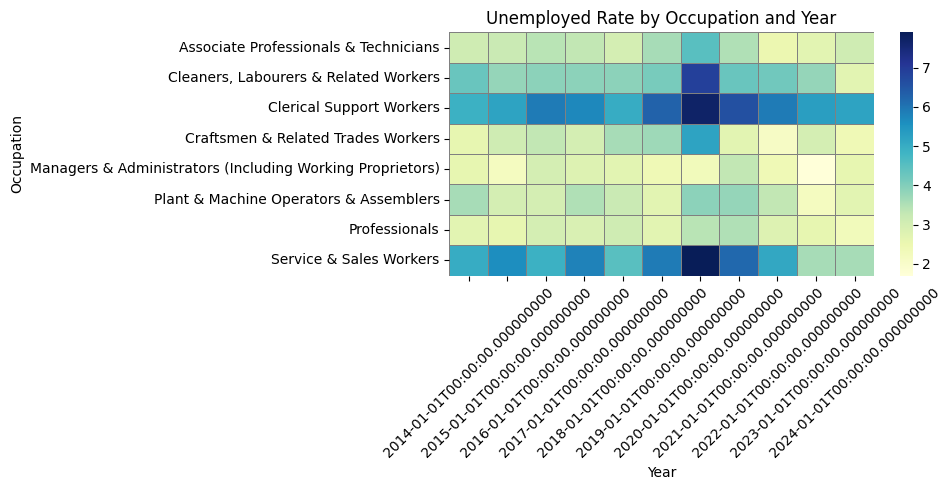

In [ ]:
# Heatmap
# Seaborn Example:
# Pivot into a matrix with occupations as rows and years as columns
pivot = df.pivot(index='occupation', columns='year', values='unemployed_rate')

# Plot heatmap
plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('Unemployed Rate by Occupation and Year')
plt.xlabel('Year')
plt.ylabel('Occupation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotly Example:#
fig = px.imshow(pivot,
                labels=dict(x="Year", y="Occupation", color="Unemployed Rate"),
                x=pivot.columns,
                y=pivot.index,
                color_continuous_scale='YlGnBu')

fig.update_layout(title="Unemployed Rate by Occupation and Year",
                  xaxis_tickangle=-25)

fig.show()


> Clerical Support Workers, Service & Sales Workers, and Cleaners consistently show higher unemployment, with a pronounced spike during 2020. Professionals and Managers remain relatively insulated, highlighting a persistent gap between lower- and higher-skilled occupations.

### Share of unemployment in Singapore by occupation (2014–2024).

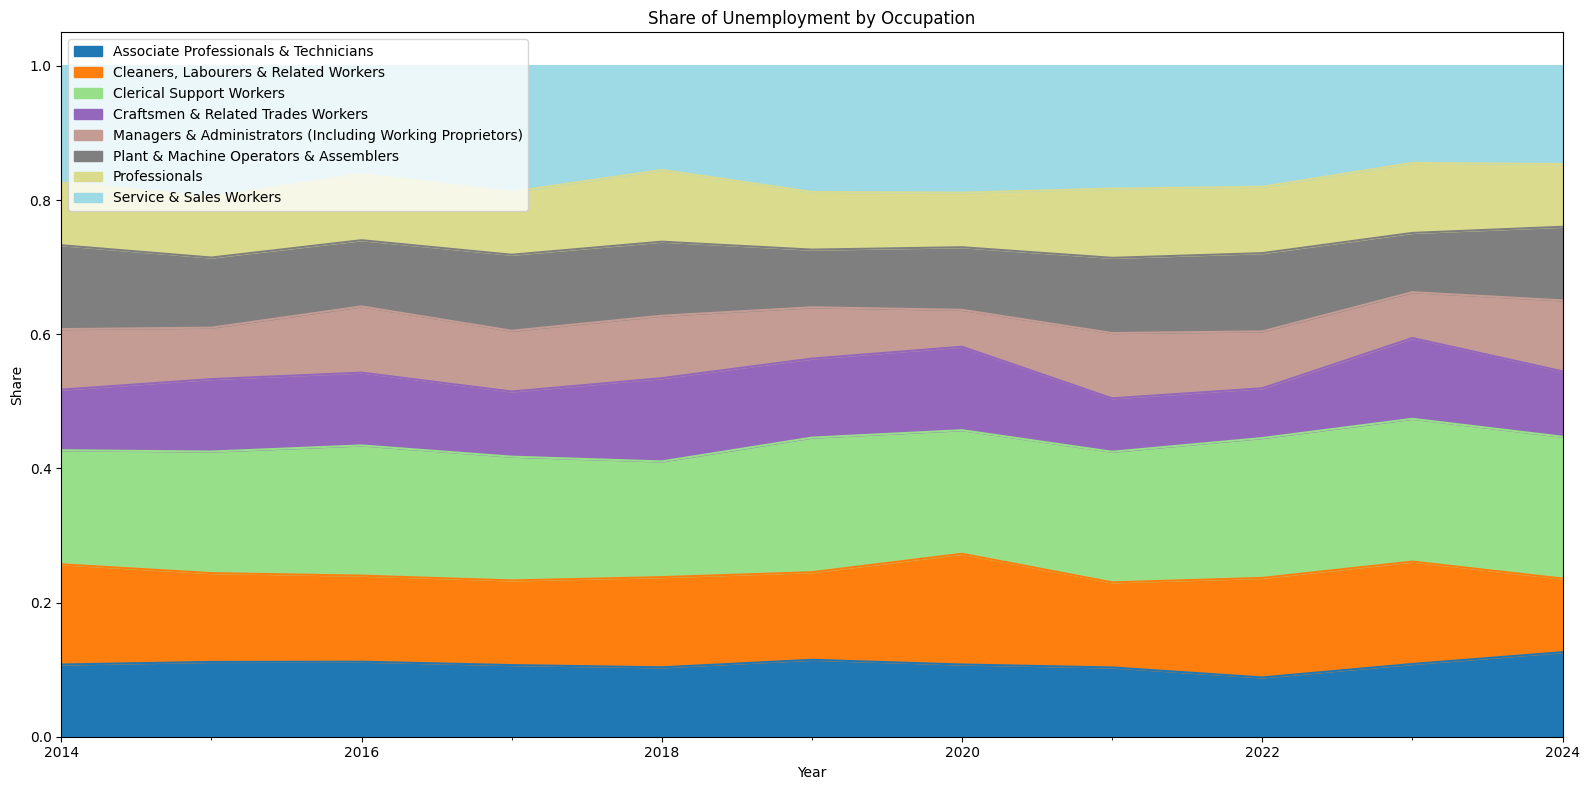

In [ ]:
#Seaborn Example:
# Prepare df so columns are occupations, index=year, values=unemployment or proportion
pivot_sum_df = df.pivot_table(index='year', columns='occupation', values='unemployed_rate', aggfunc='sum')

pivot_sum_df = pivot_sum_df.divide(pivot_sum_df.sum(axis=1), axis=0)  # for proportions/%
pivot_sum_df.plot.area(figsize=(16,8), colormap='tab20')
plt.title('Share of Unemployment by Occupation')
plt.ylabel('Share')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


#Plotly Example:
fig = px.area(pivot_sum_df.reset_index(), x='year', y=pivot_sum_df.columns,
              title='Share of Unemployment by Occupation (2014-2024)',
              groupnorm='fraction')
fig.show()

> Lower-skilled groups, particularly Clerical Support Workers and Service & Sales Workers, contribute disproportionately to overall unemployment, with a marked surge in 2020. Higher-skilled occupations such as Professionals and Managers consistently account for a smaller share, reflecting greater resilience.